In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
# from SZstacker import SZMapStacker # type: ignore
from utils import ksz_from_delta_sigma

from stacker import SimulationStacker

import illustris_python as il

import yaml
import argparse
from pathlib import Path


In [2]:
# Define configuration explicitly
from tabnanny import verbose

# Extract configuration parameters

redshift = 0.4
loadField = False
saveField = False
radDistance = 1.0
pType = 'gas'
projection = 'yz'

maskHaloes = False
maskRadii = 3.0

sim_type = 'IllustrisTNG'
snapshot = 74
sim_name = 'L50n512_SB35'

# Plotting parameters

plotErrorBars = True
figName = 'DSigma_profiles_yz'

colourmaps = ['hot', 'cool']

sims = [0, 598, 580]

number_density = [2e-4, 5.4e-4, 6e-4, 1e-3, 2.4e-3]


t0 = time.time()




In [3]:

# Get colormap
colourmap = matplotlib.colormaps[colourmaps[0]]
colours = [colourmap(0.5)]  # Single color since we have one simulation

if verbose:
    print(f"Processing simulation of type: {sim_type}")

profiles0_all_sims = []
profiles1_all_sims = []
OmegaBaryons = []
OmegaMatters = []

for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    stacker_tot = SimulationStacker(s, snapshot, 
                                simType=sim_type)

    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])
    
    ## Corresponding to halo number in 50 Mpc/h box: [25, 68, 75, 125, 300]
    profiles0_all = []
    profiles1_all = []
    for n_density in number_density:
        radii0, profiles0 = stacker.stackMap('gas', filterType='cumulative', minRadius=1.0, maxRadius=6.0,
                                            save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
                                            projection=projection)
        radii1, profiles1 = stacker_tot.stackMap('total', filterType='cumulative', minRadius=1.0, maxRadius=6.0,
                                                save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
                                                projection=projection, mask=maskHaloes, maskRad=maskRadii)

        profiles0_all.append(profiles0)
        profiles1_all.append(profiles1)

    profiles0_all_sims.append(profiles0_all)
    profiles1_all_sims.append(profiles1_all)


Processing simulation: L50n512_SB35 simulation 0
Box size: 50000.0 kpc/h , Map size at z=0.4674218694859129: 146.16 arcmin
Processed 0 snapshots, time elapsed: 1.57 seconds
Processed 10 snapshots, time elapsed: 18.15 seconds
Binned statistic time: 26.782449960708618
Number of halos selected: 25 at Mass threshold:  2.61e+13 ~  2.78e+14 Msun/h
Box size: 50000.0 kpc/h , Map size at z=0.4674218694859129: 146.16 arcmin
Processed 0 snapshots, time elapsed: 1.42 seconds
Processed 10 snapshots, time elapsed: 16.79 seconds
Binned statistic time: 25.220024585723877
Processed 0 snapshots, time elapsed: 1.86 seconds
Processed 10 snapshots, time elapsed: 20.62 seconds
Binned statistic time: 30.162170886993408
Processed 0 snapshots, time elapsed: 0.12 seconds
Processed 10 snapshots, time elapsed: 1.71 seconds
Binned statistic time: 2.503453254699707
Processed 0 snapshots, time elapsed: 0.00 seconds
Processed 10 snapshots, time elapsed: 0.12 seconds
Binned statistic time: 0.2560245990753174
Number of

In [4]:
mass_strings = [['Number of halos selected: 25 at Mass threshold:  2.61e+13 ~  2.78e+14 Msun/h',
'Number of halos selected: 67 at Mass threshold:  1.32e+13 ~  2.78e+14 Msun/h',
'Number of halos selected: 75 at Mass threshold:  1.20e+13 ~  2.78e+14 Msun/h',
'Number of halos selected: 125 at Mass threshold:  7.74e+12 ~  2.78e+14 Msun/h',
'Number of halos selected: 300 at Mass threshold:  2.92e+12 ~  2.78e+14 Msun/h'],
[
"Number of halos selected: 25 at Mass threshold:  2.18e+12 ~  2.74e+13 Msun/h",
"Number of halos selected: 67 at Mass threshold:  6.75e+11 ~  2.74e+13 Msun/h",
"Number of halos selected: 75 at Mass threshold:  5.71e+11 ~  2.74e+13 Msun/h",
"Number of halos selected: 125 at Mass threshold:  3.10e+11 ~  2.74e+13 Msun/h",
"Number of halos selected: 300 at Mass threshold:  1.48e+11 ~  2.74e+13 Msun/h"],
[
'Number of halos selected: 25 at Mass threshold:  1.67e+13 ~  1.44e+14 Msun/h',
'Number of halos selected: 67 at Mass threshold:  6.90e+12 ~  1.44e+14 Msun/h',
'Number of halos selected: 75 at Mass threshold:  6.14e+12 ~  1.44e+14 Msun/h',
'Number of halos selected: 125 at Mass threshold:  3.89e+12 ~  1.44e+14 Msun/h',
'Number of halos selected: 300 at Mass threshold:  1.60e+12 ~  1.44e+14 Msun/h']
]


In [5]:
# Save data in a format that handles variable array sizes
save_data = {}
save_data['radii0'] = radii0
save_data['number_density'] = number_density
save_data['sims'] = sims
save_data['mass_strings'] = np.array(mass_strings, dtype=object)

# Save tau and total profiles separately for each sim and density
for sim_idx, sim_id in enumerate(sims):
    for density_idx, density in enumerate(number_density):
        gas_key = f'gas_sim{sim_id}_density{density_idx}'
        total_key = f'total_sim{sim_id}_density{density_idx}'
        save_data[gas_key] = profiles0_all_sims[sim_idx][density_idx]
        save_data[total_key] = profiles1_all_sims[sim_idx][density_idx]

np.savez(
    f"CAMELS_{sim_name}_gas_cumulative_profiles_low_high_fiducial_feedback.npz",
    **save_data
) 


In [31]:
# Load the saved data
loaded_data = np.load(f"CAMELS_{sim_name}_gas_DSigma_profiles_low_high_fiducial_feedback.npz")

# Extract the basic arrays
radii0 = loaded_data['radii0']
number_density = loaded_data['number_density']
sims = loaded_data['sims']

# Reconstruct the profiles arrays
profiles0_all_sims = []
profiles1_all_sims = []

for sim_idx, sim_id in enumerate(sims):
    profiles0_all = []
    profiles1_all = []
    
    for density_idx, density in enumerate(number_density):
        gas_key = f'gas_sim{sim_id}_density{density_idx}'
        total_key = f'total_sim{sim_id}_density{density_idx}'
        
        profiles0_all.append(loaded_data[gas_key])
        profiles1_all.append(loaded_data[total_key])
    
    profiles0_all_sims.append(profiles0_all)
    profiles1_all_sims.append(profiles1_all)

print(f"Loaded data for {len(sims)} simulations with {len(number_density)} density bins")

Loaded data for 3 simulations with 5 density bins


(11, 25) (11, 25)
(11, 67) (11, 67)
(11, 75) (11, 75)
(11, 125) (11, 125)
(11, 300) (11, 300)
(11, 25) (11, 25)
(11, 67) (11, 67)
(11, 75) (11, 75)
(11, 125) (11, 125)
(11, 300) (11, 300)
(11, 25) (11, 25)
(11, 67) (11, 67)
(11, 75) (11, 75)
(11, 125) (11, 125)
(11, 300) (11, 300)


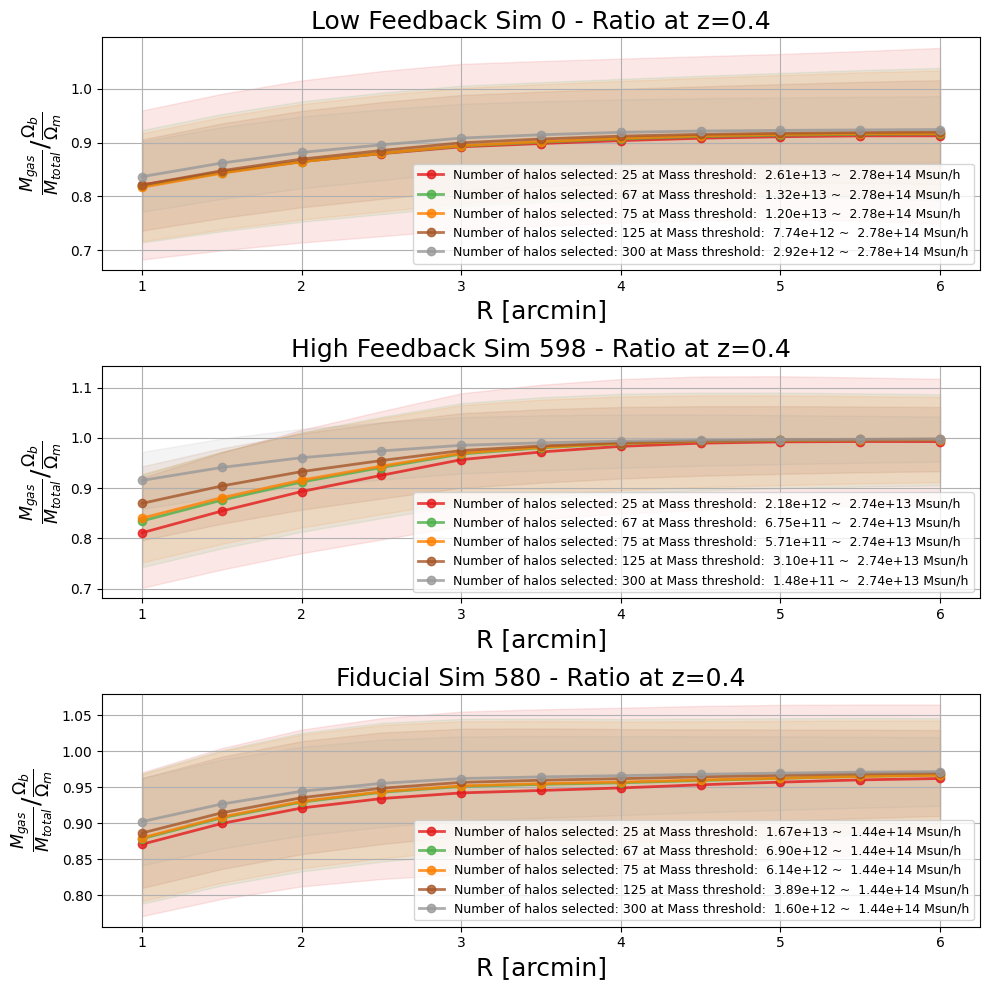

Processing completed in 1695.60 seconds


In [7]:

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
colors_list = plt.cm.Set1(np.linspace(0, 1, len(number_density)))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = profiles0_all_sims[sim_index]
    profiles1_all = profiles1_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i]
        profiles1 = profiles1_all[i]

        print(profiles0.shape, profiles1.shape)
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            title_label = f'Low Feedback Sim {sims[sim_index]}'
        elif sim_index == 1:
            title_label = f'High Feedback Sim {sims[sim_index]}'
        else:
            title_label = f'Fiducial Sim {sims[sim_index]}'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls='-', alpha=0.8, marker='o', color=color, 
                       label=mass_strings[sim_index][i])

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.set_ylabel(r'$\frac{M_{gas}}{M_{total}}/\frac{\Omega_{b}}{\Omega_{m}} $', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label} - Ratio at z={redshift}', fontsize=18)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

(11, 25) (11, 25)
(11, 67) (11, 67)
(11, 75) (11, 75)
(11, 125) (11, 125)
(11, 300) (11, 300)
(11, 25) (11, 25)
(11, 67) (11, 67)
(11, 75) (11, 75)
(11, 125) (11, 125)
(11, 300) (11, 300)
(11, 25) (11, 25)
(11, 67) (11, 67)
(11, 75) (11, 75)
(11, 125) (11, 125)
(11, 300) (11, 300)


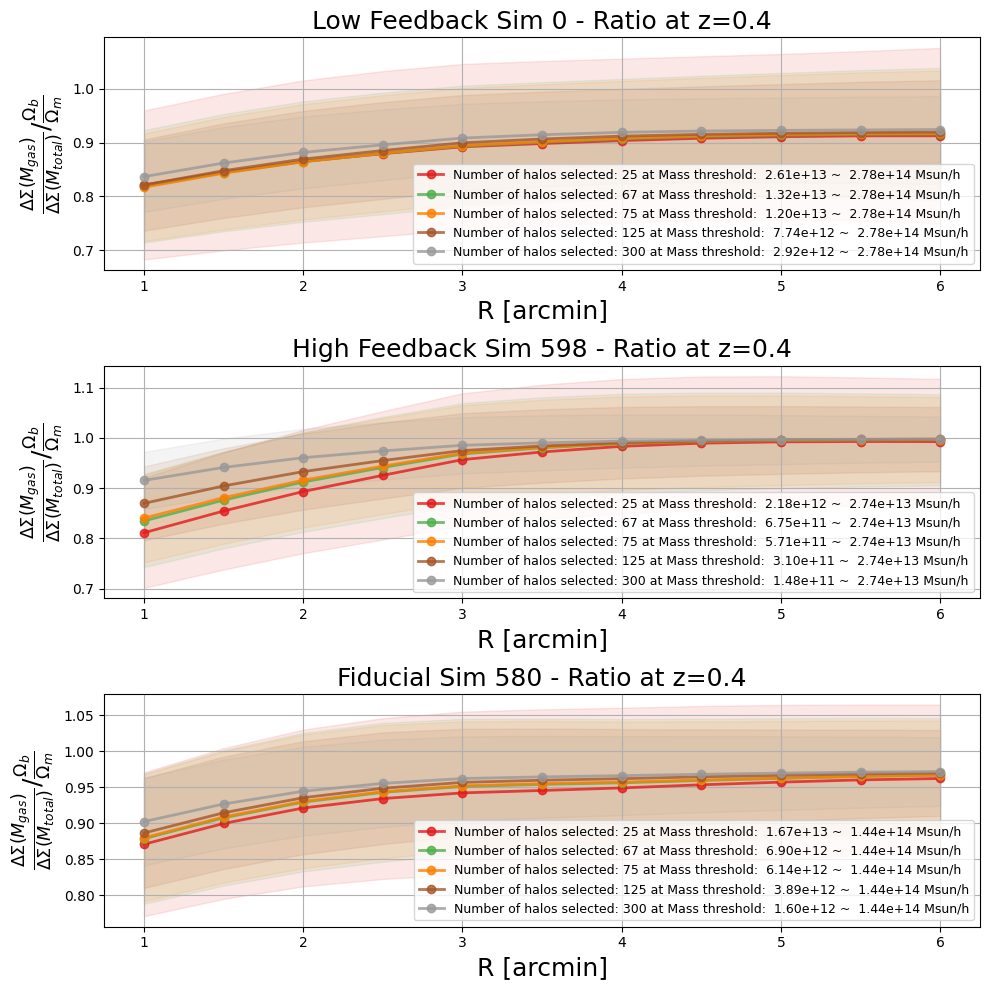

Processing completed in 1696.23 seconds


In [8]:

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
colors_list = plt.cm.Set1(np.linspace(0, 1, len(number_density)))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = profiles0_all_sims[sim_index]
    profiles1_all = profiles1_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i]
        profiles1 = profiles1_all[i]

        print(profiles0.shape, profiles1.shape)
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            title_label = f'Low Feedback Sim {sims[sim_index]}'
        elif sim_index == 1:
            title_label = f'High Feedback Sim {sims[sim_index]}'
        else:
            title_label = f'Fiducial Sim {sims[sim_index]}'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls='-', alpha=0.8, marker='o', color=color, 
                       label=mass_strings[sim_index][i])

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.set_ylabel(r'$\frac{\Delta \Sigma (M_{gas})}{\Delta \Sigma (M_{total})}/\frac{\Omega_{b}}{\Omega_{m}} $', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label} - Ratio at z={redshift}', fontsize=18)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

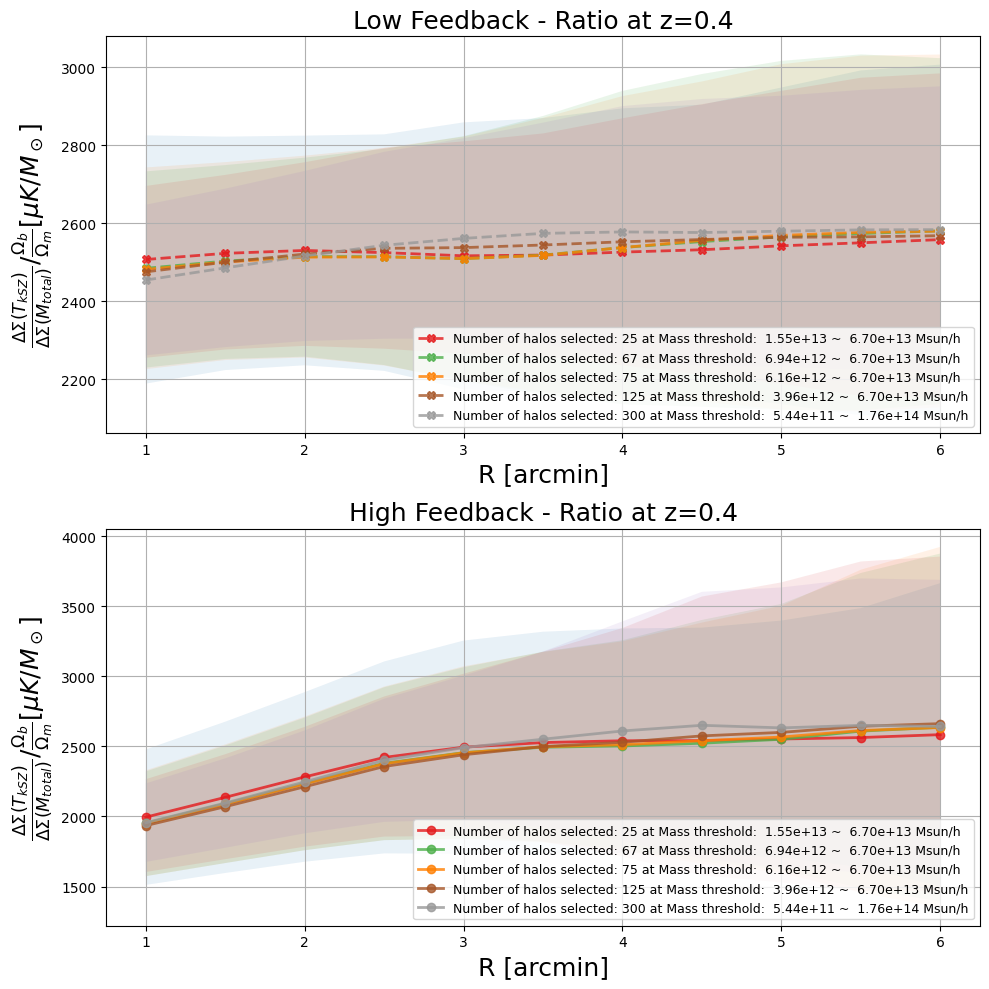

Processing completed in 2234.42 seconds


In [14]:

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

try:
    OmegaBaryon = stacker_tot.header['OmegaBaryon']
except KeyError:
    OmegaBaryon = 0.0456  # Default value for Illustris-1

# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
colors_list = plt.cm.Set1(np.linspace(0, 1, len(number_density)))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = profiles0_all_sims[sim_index]
    profiles1_all = profiles1_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i] * (T_CMB * v_c * 1e6) # convert to microK
        profiles1 = profiles1_all[i]
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            marker = 'X'
            ls = '--'
            title_label = 'Low Feedback'
        else:
            marker = 'o'
            ls = '-'
            title_label = 'High Feedback'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls=ls, alpha=0.8, marker=marker, color=color, 
                       label=mass_strings[i])

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.set_ylabel(r'$\frac{\Delta \Sigma (T_{kSZ})}{\Delta \Sigma (M_{total})}/\frac{\Omega_{b}}{\Omega_{m}}  [\mu K/M_\odot]$', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label} - Ratio at z={redshift}', fontsize=18)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

In [26]:
profiles1.mean(), profiles0.mean()

(np.float64(20312312096.09934), np.float64(0.05483369890348422))

In [32]:
profiles1 = ksz_from_delta_sigma(profiles1 * u.Msun / u.pc**2, redshift, delta_sigma_is_comoving=True, cosmology=cosmo) # convert to kSZ


In [33]:
profiles1.mean(), profiles0.mean()

(np.float64(-15964628126.670963), np.float64(149.55270792180454))